In [1]:
import jax.numpy as jnp
import jax.ops
import scipy as scipy
import scipy.integrate
import scipy.optimize
from jax import jit
from functools import partial
import numpy as np
from jax.experimental.ode import odeint
from ticktack import load_presaved_model, Box, Flow, CarbonBoxModel
import numpy as np
from ticktack import fitting, resample
from tqdm import tqdm
import matplotlib.pyplot as plt
from jax_cosmo.scipy.interpolate import InterpolatedUnivariateSpline
from jax.lax import cond, dynamic_update_slice, fori_loop, dynamic_slice, sub
import matplotlib as mpl
mpl.style.use('seaborn-colorblind')
from matplotlib.lines import Line2D
from scipy.interpolate import interp1d

In [2]:
colors = mpl.rcParams['axes.prop_cycle'].by_key()['color']

In [3]:
sf = fitting.SingleFitter('Guttler15', 'Guttler15')
sf.load_data("993AD.csv")
sf.compile_production_model(model="flexible_sinusoid")
spike_offset = sf.dc14(np.array([9.93076308e+02, 8.70731972e-01, 0, 3.75125549e+00, 0]))

INFO[2022-03-07 16:06:11,188]: Unable to initialize backend 'tpu_driver': Not found: Unable to find driver in registry given worker: 
INFO[2022-03-07 16:06:11,189]: Unable to initialize backend 'gpu': Not found: Could not find registered platform with name: "cuda". Available platform names are: Host Interpreter
INFO[2022-03-07 16:06:11,191]: Unable to initialize backend 'tpu': Invalid argument: TpuPlatform is not available.
WARNING[2022-03-07 16:06:11,192]: No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [4]:
def tt(time, aa):
    return jnp.interp(time,sf.time_data,aa)

In [5]:
sf = fitting.SingleFitter('Guttler15', 'Guttler15')
sf.load_data("data/ETH.csv")
f = interp1d(sf.time_data, sf.d14c_data)
f2 = interp1d(sf.time_data, sf.d14c_data_error)
sf.time_data = sf.annual
sf.d14c_data = f(sf.time_data)
sf.d14c_data_error = f2(sf.time_data)

In [6]:
sf.d14c_data[40:55] = sf.d14c_data[40:55] - spike_offset

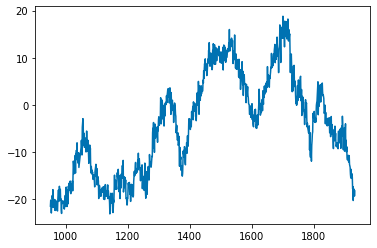

In [7]:
plt.plot(sf.time_data, sf.d14c_data)

In [8]:
chain = sf.MC_reconstruct(iters=500)

100%|█████████████████████████████████████████████████████████████████████████████████| 500/500 [03:52<00:00,  2.15it/s]


In [9]:
mean = np.mean(chain, axis=0)
std = np.std(chain, axis=0)

In [10]:
sf.compile_production_model(tt)
@jit
def d14c(params):
    event = sf.run_event(y0=sf.steady_state_y0, params=(params,))
    time_values = jnp.linspace(jnp.min(sf.annual), jnp.max(sf.annual) + 2, (sf.annual.size + 1) * sf.oversample)
    binned_data = sf.cbm.bin_data(event[:, sf.box_idx], sf.oversample, sf.annual, growth=sf.growth)
    gaga = (binned_data - sf.steady_state_y0[sf.box_idx]) / sf.steady_state_y0[sf.box_idx] * 1000
    return gaga+sf.offset

(-23.0, -5.0)

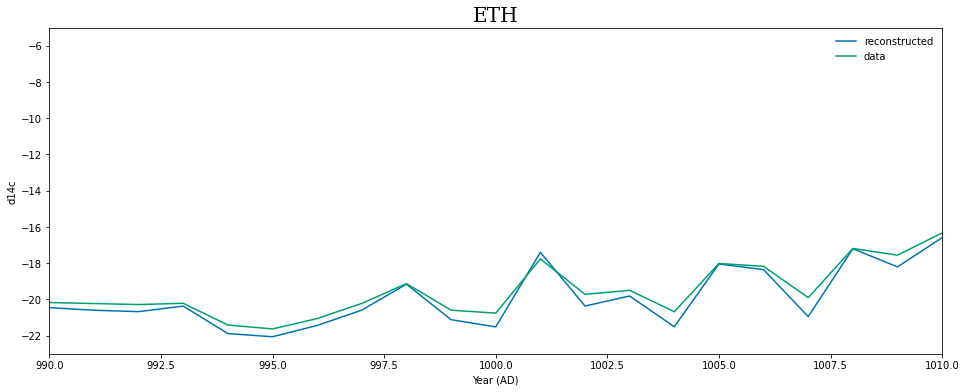

In [11]:
fig, ax = plt.subplots(figsize=(16, 6))

ax.plot(sf.time_data, sf.d14c_data)
ax.plot(sf.annual, d14c(mean))
ax.legend(['reconstructed', 'data'], frameon=False)
ax.set_title("ETH", fontfamily="serif", fontsize=20)
ax.set_ylabel("d14c");
ax.set_xlabel("Year (AD)");
ax.set_xlim(990, 1010)
ax.set_ylim(-23, -5)

In [12]:
resampler = resample.Resampler()
resampler.load_data(sf.annual, None, None)

In [13]:
def signal_resample(size=10000, l=1./9.677, sz=0.05, order=30, samples=None):
    if not np.all(samples):
        samples = np.random.multivariate_normal(resampler.y, np.diag(resampler.yerr ** 2), size=size)
    f = interp1d(resampler.x, samples, kind="cubic")
    interpolation = f(resampler.annual)
    new_sig = resampler.bandpass_super_gaussian(interpolation, l, sz, order=order)
    return new_sig

In [14]:
new_sig = signal_resample(samples=chain)

In [15]:
new_sig_real = np.real(new_sig)

100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [00:00<00:00, 640.20it/s]


Text(0.5, 1.0, 'Bandpass Production Rate')

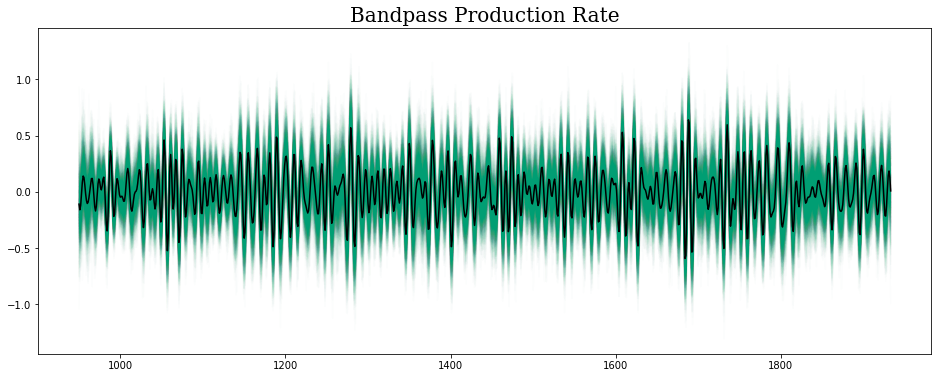

In [30]:
fig, ax = plt.subplots(figsize=(16, 6))
for i in tqdm(range(new_sig_real.shape[0])):
    ax.plot(sf.annual, new_sig_real[i, :], colors[1], alpha=0.01)
ax.plot(sf.annual, signal_resample(samples=mean), "k")
ax.set_title("Bandpass Production Rate", fontfamily="serif", fontsize=20)

In [17]:
reconstruction = np.zeros(chain.shape)
for i in tqdm(range(new_sig_real.shape[0])):
    reconstruction[i, :] = d14c(chain[i, :])

100%|█████████████████████████████████████████████████████████████████████████████████| 500/500 [02:11<00:00,  3.79it/s]


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [00:00<00:00, 702.81it/s]


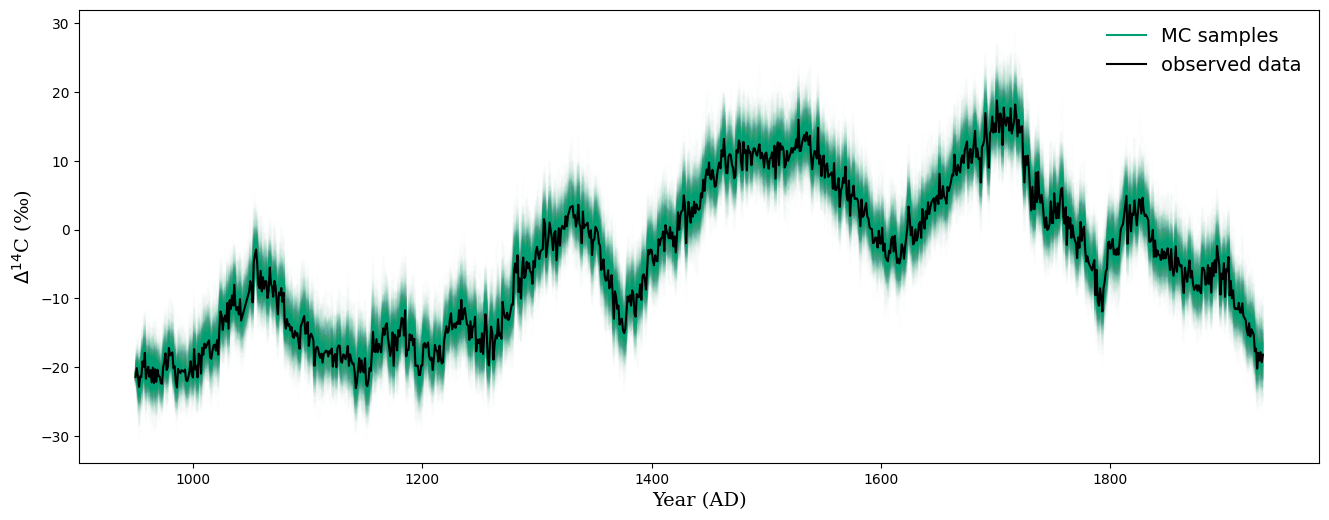

In [22]:
fig, ax = plt.subplots(figsize=(16, 6), dpi=100)
for i in tqdm(range(new_sig_real.shape[0])):
    ax.plot(sf.annual, reconstruction[i, :], color=colors[1], alpha=0.01)
ax.plot(sf.annual, sf.d14c_data, color='k')
custom_lines = [Line2D([0], [0], color=colors[1], lw=1.5, label="MC samples")]
custom_lines.append(Line2D([0], [0], color='k', label="observed data"))
ax.legend(handles=custom_lines, frameon=False, fontsize=14);
# ax.set_title("$\Delta ^{14}$C", fontfamily="serif", fontsize=20);
ax.set_xlabel("Year (AD)", fontfamily="serif", fontsize=14)
ax.set_ylabel("$\Delta^{14}$C (‰)", fontfamily="serif", fontsize=14);
fig.savefig("ETH-d14c.jpg")

In [19]:
new_sig_reconstruction = signal_resample(samples=reconstruction)

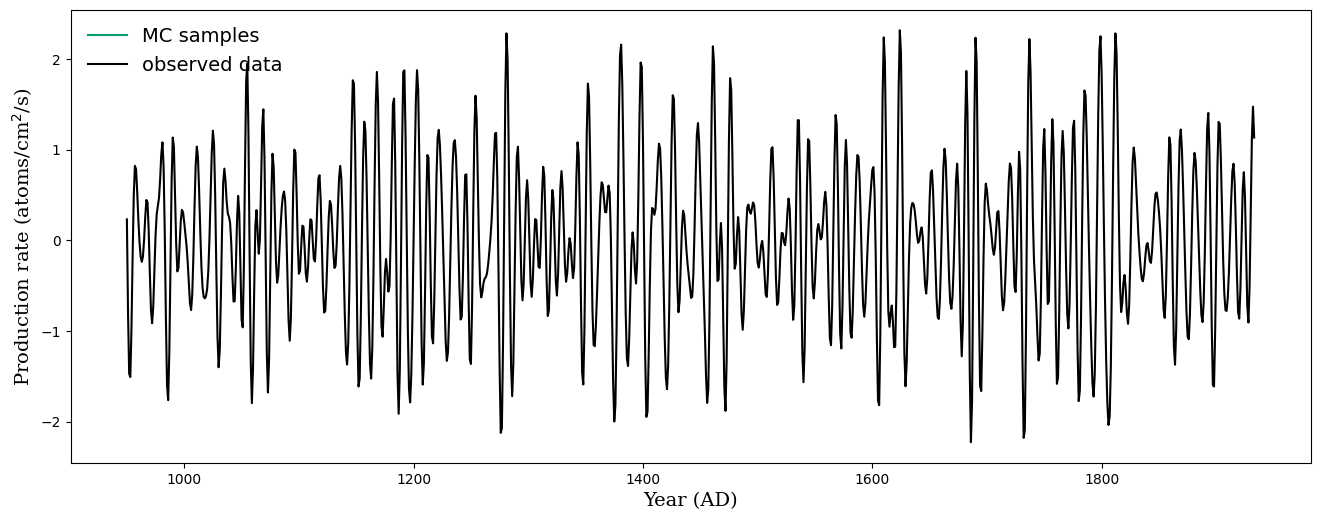

In [25]:
fig, ax = plt.subplots(figsize=(16, 6), dpi=100)
# for i in tqdm(range(new_sig_real.shape[0])):
#     ax.plot(sf.annual, new_sig_reconstruction[i, :], color=colors[1], alpha=0.01)
ax.plot(sf.annual, signal_resample(samples= sf.d14c_data), color='k')
custom_lines = [Line2D([0], [0], color=colors[1], lw=1.5, label="MC samples")]
custom_lines.append(Line2D([0], [0], color='k', label="observed data"))
ax.legend(handles=custom_lines, frameon=False, fontsize=14);
ax.set_xlabel("Year (AD)", fontfamily="serif", fontsize=14)
ax.set_ylabel("Production rate (atoms/cm$^2$/s)", fontfamily="serif", fontsize=14);
fig.savefig("ETH-rate.jpg")